# Assessment 2: CNNs for image classification

## Setup: import lib

In [1]:
## section: Data manioulation
import pandas as pd
import numpy as np
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## section: neural network
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA GeForce GTX 1650
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torch\cuda\memory.py:393: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


## Step01: Data exploration

In [3]:
## Download from cifar10
training_data = datasets.CIFAR100(
    root="data",
    train=True,
    download = True,
    transform= transforms.Compose([
        # transforms.Resize((64, 64)),  # Resize all images to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip()
    ])
)

testing_data = datasets.CIFAR100(
    root="data",
    train=False,
    download = True,
    transform= transforms.Compose([
        # transforms.Resize((64, 64)),  # Resize all images to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
num_class = len(training_data.classes)
num_class

100

### Exploratory Image analysis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Check Shape of images:  torch.Size([3, 32, 32]) 11
Preview Images with Label : apple
Show of images unique labels:  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'te

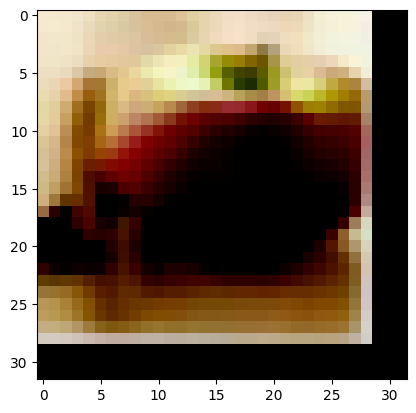

In [5]:
## check shape and labels
img, label = training_data[3]
print("Check Shape of images: ",img.shape,label)

def display_img(img,label):
  print(f"Preview Images with Label : {training_data.classes[label]}")
  plt.imshow(img.permute(1,2,0)) # for visualization following the plt need to change the shapes

#display the first image in the dataset
display_img(*training_data[2])

#Show all labels
classes = training_data.classes
print("Show of images unique labels: ",classes)

### Tranforms to Dataloader

In [6]:
batch_size = 32
## apply the dataloader
torch.manual_seed(0)
trainloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory = True
    )

testloader = torch.utils.data.DataLoader(
    testing_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory = True
    )

### Review the Batch fig and size

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 32, 32])


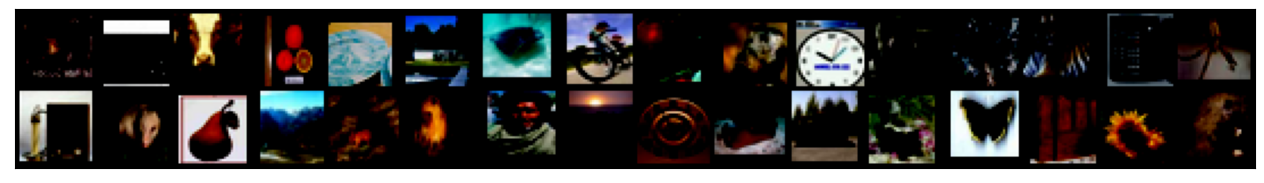

In [7]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

## show the batch fig
show_batch(trainloader)

## print the size
for batch in trainloader:
    print(batch[0].shape)  # Assuming batch[0] contains the data and batch[1] contains the labels
    break

## Base Model Functions For Image Classification

In [8]:
## adding the progress bar
import time
from tqdm import tqdm
import gc

def reset_memory():
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def train_network(model, optimizer, criterion, trainloader, testloader, num_epochs, seed=1311, num_class = num_class):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    set_seed(seed)  # Set the seed
    print('Using device:', device,"with seed: ",seed)
    print()



    # create set to collect the output
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # get the input and output
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs} Training'):
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward feed
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels.data)
            total_train += labels.size(0)

            # Then clean the cache
            torch.cuda.empty_cache()
            # then collect the garbage

        epoch_loss = running_loss / total_train
        epoch_acc = correct_train.double() / total_train
        train_loss.append(epoch_loss)
        train_accuracy.append(int(100 * epoch_acc))

        # Validation
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(testloader, desc=f'Epoch {epoch+1}/{num_epochs} Testing'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == labels.data)
                total_test += labels.size(0)



                if epoch + 1 == num_epochs:
                  class_correct = list(0. for i in range(num_class))
                  class_total = list(0. for i in range(num_class))
                  c = (preds == labels).squeeze()
                  for i in range(len(labels)):
                      label = labels[i]
                      class_correct[label] += c[i].item()
                      class_total[label] += 1



        epoch_test_loss = running_test_loss / total_test
        test_loss.append(epoch_test_loss)
        test_accuracy.append(int(100 * correct_test.double() / total_test))

        epoch_end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {100 * epoch_acc:.2f}%, '
              f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {100 * correct_test.double() / total_test:.2f}%, '
              f'Time: {epoch_end_time - epoch_start_time:.2f}s')

        if epoch + 1 == num_epochs:
          print('Accuracy for each class')
          for i in range(num_class):
            # print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
            if class_total[i] > 0:
                print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
            else:
                print('Accuracy of %5s : N/A (no training examples)' % (classes[i]))

    reset_memory()

    return train_loss, train_accuracy, test_loss, test_accuracy

## Initialize network

### network: workshop CNN

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes=num_class):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_class)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=100, bias=True)
)


### network: SimpleCNN

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=num_class):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### network: Alexnet

In [11]:
# class AlexNet(nn.Module):
#     def __init__(self, num_classes=10):
#         super(AlexNet, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
#             nn.BatchNorm2d(96),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 3, stride = 2))
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 3, stride = 2))
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(384),
#             nn.ReLU())
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(384),
#             nn.ReLU())
#         self.layer5 = nn.Sequential(
#             nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 3, stride = 2))
#         self.fc = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(9216, 4096),
#             nn.ReLU())
#         self.fc1 = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU())
#         self.fc2= nn.Sequential(
#             nn.Linear(4096, num_classes))

#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.layer5(out)
#         out = out.reshape(out.size(0), -1)
#         out = self.fc(out)
#         out = self.fc1(out)
#         out = self.fc2(out)
#         return out

class AlexNet(nn.Module):
    def __init__(self, num_classes=num_class):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



### network: ResNet18

In [12]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size=3, stride=stride, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size=3,stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride,
                          bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=num_class):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

## Train the network

In [13]:
def plot_loss(train_loss, val_loss):
    """ Plot the history of losses"""
    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show();




def plot_acc(train_acc, val_acc):
    """ Plot the accuracies in each epoch"""
    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracies')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.show();

results = []

### Train the network - net

In [14]:
import torch.optim as optim

net = Net().to(device)
model = net
num_epochs = 15

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

net_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(net_results[0], net_results[2])
plot_acc(net_results[1], net_results[3])

# save the model info
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Using device: cuda with seed:  1311



Epoch 1/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 75.49it/s]


Epoch 1/15, Train Loss: 4.0680, Train Acc: 6.79%, Test Loss: 3.7252, Test Acc: 12.51%, Time: 70.24s


Epoch 2/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 53.16it/s]


Epoch 2/15, Train Loss: 3.6235, Train Acc: 13.64%, Test Loss: 3.3927, Test Acc: 17.68%, Time: 63.76s


Epoch 3/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 81.67it/s]


Epoch 3/15, Train Loss: 3.4125, Train Acc: 17.37%, Test Loss: 3.2532, Test Acc: 20.06%, Time: 47.69s


Epoch 4/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 72.89it/s]


Epoch 4/15, Train Loss: 3.3004, Train Acc: 19.46%, Test Loss: 3.1481, Test Acc: 22.74%, Time: 46.12s


Epoch 5/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 72.92it/s]


Epoch 5/15, Train Loss: 3.2102, Train Acc: 21.28%, Test Loss: 3.1430, Test Acc: 22.74%, Time: 49.21s


Epoch 6/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 70.18it/s]


Epoch 6/15, Train Loss: 3.1404, Train Acc: 22.63%, Test Loss: 3.0315, Test Acc: 24.75%, Time: 58.08s


Epoch 7/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 69.15it/s]


Epoch 7/15, Train Loss: 3.0936, Train Acc: 23.50%, Test Loss: 2.9693, Test Acc: 26.17%, Time: 54.93s


Epoch 8/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 69.22it/s]


Epoch 8/15, Train Loss: 3.0535, Train Acc: 24.47%, Test Loss: 2.9557, Test Acc: 26.25%, Time: 53.31s


Epoch 9/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 73.75it/s]


Epoch 9/15, Train Loss: 3.0180, Train Acc: 24.74%, Test Loss: 2.9509, Test Acc: 26.63%, Time: 52.70s


Epoch 10/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 71.31it/s]


Epoch 10/15, Train Loss: 2.9918, Train Acc: 25.40%, Test Loss: 2.8955, Test Acc: 28.21%, Time: 51.82s


Epoch 11/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 52.70it/s]


Epoch 11/15, Train Loss: 2.9527, Train Acc: 26.05%, Test Loss: 2.8949, Test Acc: 27.51%, Time: 56.21s


Epoch 12/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 77.99it/s]


Epoch 12/15, Train Loss: 2.9313, Train Acc: 26.78%, Test Loss: 2.8486, Test Acc: 28.91%, Time: 55.28s


Epoch 13/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 60.40it/s]


Epoch 13/15, Train Loss: 2.9188, Train Acc: 26.92%, Test Loss: 2.8453, Test Acc: 28.92%, Time: 50.74s


Epoch 14/15 Testing: 100%|██████████| 313/313 [00:07<00:00, 43.68it/s]


Epoch 14/15, Train Loss: 2.8882, Train Acc: 27.35%, Test Loss: 2.9057, Test Acc: 27.50%, Time: 81.03s


Epoch 15/15 Training:   3%|▎         | 41/1563 [00:02<01:21, 18.67it/s]


KeyboardInterrupt: 

### Train the network - simpleCNN

Using device: cpu with seed:  1311



Epoch 1/15 Testing: 100%|██████████| 313/313 [00:12<00:00, 24.67it/s]


Epoch 1/15, Train Loss: 3.7225, Train Acc: 12.42%, Test Loss: 3.1586, Test Acc: 22.97%, Time: 164.25s


Epoch 2/15 Testing: 100%|██████████| 313/313 [00:12<00:00, 24.96it/s]


Epoch 2/15, Train Loss: 3.0639, Train Acc: 24.06%, Test Loss: 2.7722, Test Acc: 29.79%, Time: 173.22s


Epoch 3/15 Testing: 100%|██████████| 313/313 [00:12<00:00, 24.57it/s]


Epoch 3/15, Train Loss: 2.7436, Train Acc: 30.31%, Test Loss: 2.5814, Test Acc: 34.17%, Time: 172.40s


Epoch 4/15 Testing: 100%|██████████| 313/313 [00:12<00:00, 24.84it/s]


Epoch 4/15, Train Loss: 2.5498, Train Acc: 34.29%, Test Loss: 2.4194, Test Acc: 37.58%, Time: 173.41s


Epoch 5/15 Testing: 100%|██████████| 313/313 [00:12<00:00, 25.40it/s]


Epoch 5/15, Train Loss: 2.4015, Train Acc: 37.40%, Test Loss: 2.3019, Test Acc: 40.40%, Time: 171.64s


Epoch 6/15 Testing: 100%|██████████| 313/313 [00:12<00:00, 24.99it/s]


Epoch 6/15, Train Loss: 2.2939, Train Acc: 39.71%, Test Loss: 2.2538, Test Acc: 41.03%, Time: 172.88s


Epoch 7/15 Testing: 100%|██████████| 313/313 [00:13<00:00, 23.09it/s]


Epoch 7/15, Train Loss: 2.2076, Train Acc: 41.66%, Test Loss: 2.1854, Test Acc: 43.37%, Time: 172.42s


Epoch 8/15 Testing: 100%|██████████| 313/313 [00:12<00:00, 25.03it/s]


Epoch 8/15, Train Loss: 2.1343, Train Acc: 43.12%, Test Loss: 2.1859, Test Acc: 43.88%, Time: 170.06s


Epoch 9/15 Testing: 100%|██████████| 313/313 [00:12<00:00, 25.25it/s]


Epoch 9/15, Train Loss: 2.0755, Train Acc: 44.41%, Test Loss: 2.1129, Test Acc: 44.97%, Time: 172.01s


Epoch 10/15 Testing: 100%|██████████| 313/313 [00:12<00:00, 25.25it/s]


Epoch 10/15, Train Loss: 2.0270, Train Acc: 45.57%, Test Loss: 2.1558, Test Acc: 44.34%, Time: 171.53s


Epoch 11/15 Testing: 100%|██████████| 313/313 [00:12<00:00, 25.25it/s]


Epoch 11/15, Train Loss: 1.9712, Train Acc: 46.95%, Test Loss: 2.0979, Test Acc: 45.21%, Time: 171.25s


Epoch 12/15 Testing: 100%|██████████| 313/313 [00:12<00:00, 25.13it/s]


Epoch 12/15, Train Loss: 1.9406, Train Acc: 47.33%, Test Loss: 2.0898, Test Acc: 45.51%, Time: 171.83s


Epoch 13/15 Testing: 100%|██████████| 313/313 [00:12<00:00, 25.29it/s]


Epoch 13/15, Train Loss: 1.9094, Train Acc: 48.25%, Test Loss: 2.1030, Test Acc: 45.94%, Time: 170.51s


Epoch 14/15 Testing: 100%|██████████| 313/313 [00:12<00:00, 25.27it/s]


Epoch 14/15, Train Loss: 1.8750, Train Acc: 49.06%, Test Loss: 2.0774, Test Acc: 45.68%, Time: 170.50s


Epoch 15/15 Testing: 100%|██████████| 313/313 [00:12<00:00, 24.85it/s]


Epoch 15/15, Train Loss: 1.8433, Train Acc: 49.65%, Test Loss: 2.0569, Test Acc: 46.61%, Time: 170.64s
Accuracy for each class
Accuracy of apple : N/A (no training examples)
Accuracy of aquarium_fish : N/A (no training examples)
Accuracy of  baby : N/A (no training examples)
Accuracy of  bear : N/A (no training examples)
Accuracy of beaver : N/A (no training examples)
Accuracy of   bed : N/A (no training examples)
Accuracy of   bee : N/A (no training examples)
Accuracy of beetle : 100 %
Accuracy of bicycle : N/A (no training examples)
Accuracy of bottle : N/A (no training examples)
Accuracy of  bowl : N/A (no training examples)
Accuracy of   boy : N/A (no training examples)
Accuracy of bridge : N/A (no training examples)
Accuracy of   bus : N/A (no training examples)
Accuracy of butterfly : 50 %
Accuracy of camel : N/A (no training examples)
Accuracy of   can : 100 %
Accuracy of castle : N/A (no training examples)
Accuracy of caterpillar : N/A (no training examples)
Accuracy of cattle 

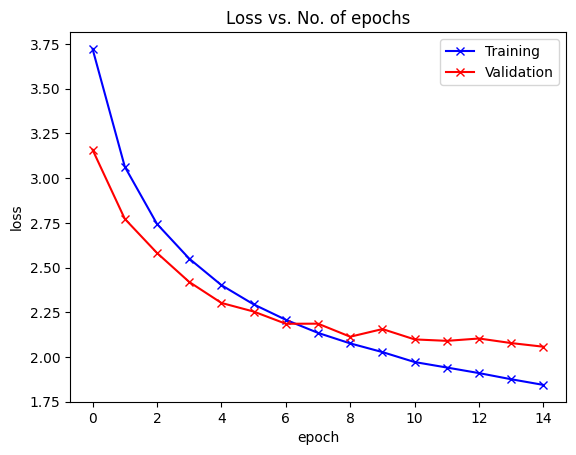

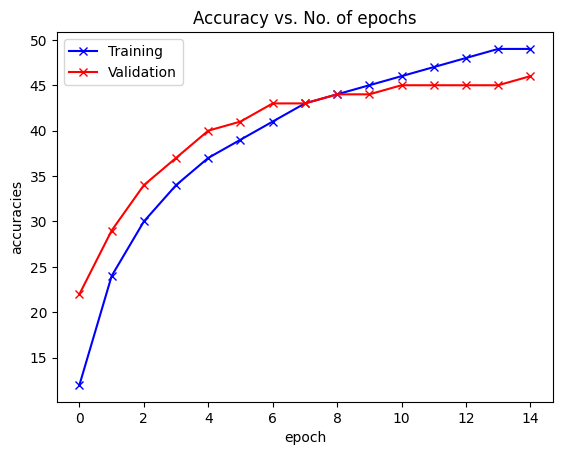

In [ ]:
import torch.optim as optim

simplecnn = SimpleCNN().to(device)
model = simplecnn
num_epochs = 15

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

simplecnn_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(simplecnn_results[0], simplecnn_results[2])
plot_acc(simplecnn_results[1], simplecnn_results[3])

# save the model info
PATH = './cifar_simplecnn.pth'
torch.save(simplecnn.state_dict(), PATH)

### Train the network - Alexnet

In [ ]:
import torch.optim as optim

alexnet = AlexNet().to(device)
model = alexnet
num_epochs = 15

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

alexnet_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(alexnet_results[0], alexnet_results[2])
plot_acc(alexnet_results[1], alexnet_results[3])

# save the model info
PATH = './cifar_alexnet.pth'
torch.save(alexnet.state_dict(), PATH)

Using device: cpu with seed:  1311



Epoch 1/15 Training:  70%|██████▉   | 1087/1563 [37:05<18:27,  2.33s/it]

### Train the network - Resnet18

In [ ]:
import torch.optim as optim

resnet18 = ResNet18().to(device)
model = resnet18
num_epochs = 15

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

resnet18_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(resnet18_results[0], resnet18_results[2])
plot_acc(resnet18_results[1], resnet18_results[3])

# save the model info
PATH = './cifar_resnet18.pth'
torch.save(resnet18.state_dict(), PATH)

### Train the network - Resnet34

In [ ]:
import torch.optim as optim

resnet34 = ResNet34().to(device)
model = resnet34
num_epochs = 15

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

resnet34_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(resnet34_results[0], resnet34_results[2])
plot_acc(resnet34_results[1], resnet34_results[3])

# save the model info
PATH = './cifar_resnet34.pth'
torch.save(resnet34.state_dict(), PATH)

## Test the Model

In [ ]:
alexnet_results

### Testing data

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

In [ ]:
net = Net()
net.load_state_dict(torch.load('./cifar_net.pth'))

simplecnn = SimpleCNN()
simplecnn.load_state_dict(torch.load('./cifar_simplecnn.pth'))

alexnet = AlexNet()
alexnet.load_state_dict(torch.load('./cifar_alexnet.pth'))

resnet18 = ResNet18()
resnet18.load_state_dict(torch.load('./cifar_resnet18.pth'))

resnet34 = ResNet34()
resnet34.load_state_dict(torch.load('./cifar_resnet34.pth'))

In [ ]:
def test_set_acc(testloader, model):
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
          inputs, labels = data
          # inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)

          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs, 1)
          correct += torch.sum(preds == labels.data)
          total += labels.size(0)

          c = (preds == labels).squeeze()
          for i in range(len(labels)):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
print('Model: net')
test_set_acc(testloader, net)

In [ ]:
print('Model: simplecnn')
test_set_acc(testloader, simplecnn)

In [ ]:
print('Model: alexnet')
test_set_acc(testloader, alexnet)

In [ ]:
print('Model: resnet18')
test_set_acc(testloader, resnet18)

In [ ]:
print('Model: resnet34')
test_set_acc(testloader, resnet34)